In [1]:
q= '''
SELECT *
FROM
    (SELECT *,
    row_number()
    OVER
        (PARTITION BY "open_time"
        ORDER BY "close_time" DESC, Api_Invocation_Time DESC, write_time DESC)
    AS row_number
    FROM "sagemaker_featurestore"."btcpricedata_1704246894")
WHERE row_number = 1 ORDER BY close_time ASC limit 10000;
'''

In [2]:
from sagemaker.feature_store.feature_group import FeatureGroup
import boto3
import pandas as pd
import numpy as np
import io
from sagemaker.session import Session
from sagemaker import get_execution_role
sagemaker_session = Session()

feature_group = FeatureGroup(name = 'BtcPriceData')

query = feature_group.athena_query()

table = query.table_name
table
default_s3_bucket_name = 'binance-btc-prices'

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [3]:

# run Athena query. The output is loaded to a Pandas dataframe.
dataset = pd.DataFrame()
query.run(query_string=q, output_location='s3://'+default_s3_bucket_name+'/query_results/')
query.wait()
dataset = query.as_dataframe()

In [4]:
dataset['open_time'] = pd.to_datetime(dataset['open_time'], unit='ms').dt.strftime('%Y-%m-%d %T')
dataset

,open_time,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,open_price,write_time,api_invocation_time,is_deleted,row_number
0,2019-09-09 00:00:00,10392.41,10376.45,10390.08,27.884150,1.567987e+09,289616.874870,626.0,12.492958,10381.24,2024-01-08 18:11:09.934,2024-01-08 18:05:58.000,False,1
1,2019-09-09 00:05:00,10393.94,10368.87,10372.31,36.750216,1.567988e+09,381470.813473,614.0,22.195335,10390.74,2024-01-08 18:11:07.429,2024-01-08 18:05:58.000,False,1
2,2019-09-09 00:10:00,10386.24,10368.88,10374.20,38.888045,1.567988e+09,403560.679883,640.0,19.145836,10372.31,2024-01-08 18:11:30.173,2024-01-08 18:05:58.000,False,1
3,2019-09-09 00:15:00,10387.83,10368.89,10384.89,24.997683,1.567988e+09,259393.681444,712.0,11.799247,10374.18,2024-01-08 18:11:10.880,2024-01-08 18:05:58.000,False,1
4,2019-09-09 00:20:00,10396.00,10382.40,10394.20,18.551736,1.567989e+09,192759.198389,571.0,9.729698,10386.25,2024-01-08 18:11:06.932,2024-01-08 18:05:58.000,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2019-10-13 16:55:00,8424.95,8419.00,8422.15,48.320004,1.570986e+09,406930.812989,802.0,26.893385,8420.66,2024-01-08 18:11:03.819,2024-01-08 18:07:11.000,False,1
9996,2019-10-13 17:00:00,8437.15,8421.07,8423.15,86.248372,1.570986e+09,726802.562882,1100.0,45.301036,8422.95,2024-01-08 18:08:21.381,2024-01-08 18:07:11.000,False,1
9997,2019-10-13 17:05:00,8431.42,8421.13,8426.14,72.286456,1.570987e+09,609133.602427,1028.0,45.706006,8421.13,2024-01-08 18:11:01.366,2024-01-08 18:07:11.000,False,1
9998,2019-10-13 17:10:00,8441.25,8424.96,8441.25,90.897383,1.570987e+09,766786.673574,1683.0,61.283856,8426.14,2024-01-08 18:10:56.602,2024-01-08 18:07:11.000,False,1


In [8]:
dataset.set_index('open_time',inplace = True)

In [21]:
dataset

,high_price,low_price,close_price,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,open_price,write_time,api_invocation_time,is_deleted,row_number
open_time,,,,,,,,,,,,,
2019-09-09 00:00:00,10392.41,10376.45,10390.08,27.884150,1.567987e+09,289616.874870,626.0,12.492958,10381.24,2024-01-08 18:11:09.934,2024-01-08 18:05:58.000,False,1
2019-09-09 00:05:00,10393.94,10368.87,10372.31,36.750216,1.567988e+09,381470.813473,614.0,22.195335,10390.74,2024-01-08 18:11:07.429,2024-01-08 18:05:58.000,False,1
2019-09-09 00:10:00,10386.24,10368.88,10374.20,38.888045,1.567988e+09,403560.679883,640.0,19.145836,10372.31,2024-01-08 18:11:30.173,2024-01-08 18:05:58.000,False,1
2019-09-09 00:15:00,10387.83,10368.89,10384.89,24.997683,1.567988e+09,259393.681444,712.0,11.799247,10374.18,2024-01-08 18:11:10.880,2024-01-08 18:05:58.000,False,1
2019-09-09 00:20:00,10396.00,10382.40,10394.20,18.551736,1.567989e+09,192759.198389,571.0,9.729698,10386.25,2024-01-08 18:11:06.932,2024-01-08 18:05:58.000,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-10-13 16:55:00,8424.95,8419.00,8422.15,48.320004,1.570986e+09,406930.812989,802.0,26.893385,8420.66,2024-01-08 18:11:03.819,2024-01-08 18:07:11.000,False,1
2019-10-13 17:00:00,8437.15,8421.07,8423.15,86.248372,1.570986e+09,726802.562882,1100.0,45.301036,8422.95,2024-01-08 18:08:21.381,2024-01-08 18:07:11.000,False,1
2019-10-13 17:05:00,8431.42,8421.13,8426.14,72.286456,1.570987e+09,609133.602427,1028.0,45.706006,8421.13,2024-01-08 18:11:01.366,2024-01-08 18:07:11.000,False,1


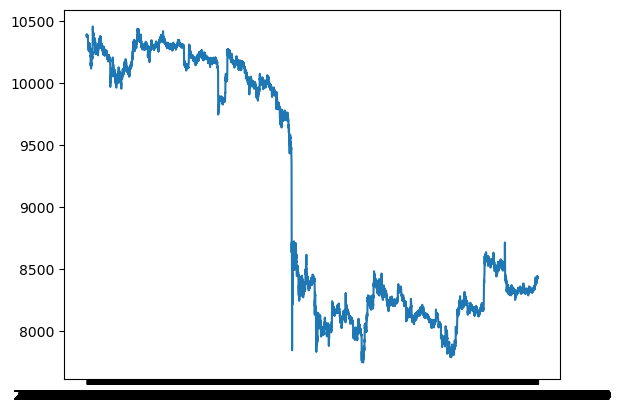

In [23]:
import matplotlib.pyplot as plt
plt.plot(dataset.index, dataset.close_price)

In [158]:
df = pd.read_csv('btc.csv')
df.close_time = pd.to_datetime(df.close_time)
df.close_time = df.close_time.dt.strftime("%Y-%m-%d")
df.sort_values(by = 'close_time',ascending =True)
df.set_index('close_time',inplace = True)

In [159]:
df = df.close

In [160]:
df

close_time
2018-01-01    13380.00
2018-01-02    14675.11
2018-01-03    14919.51
2018-01-04    15059.54
2018-01-05    16960.39
                ...   
2023-12-14    43022.26
2023-12-15    41940.30
2023-12-16    42278.03
2023-12-17    41718.89
2023-12-18    41327.70
Name: close, Length: 2178, dtype: float64

In [161]:
n_steps = 4
acc = []
for i in range(len(df) - n_steps + 1):
    temp = pd.DataFrame()
    line = list(df[i: i+ n_steps ].values)
    line.insert(0,df.index[i+ n_steps - 1])
    acc.append(line)
    

In [162]:
line

['2023-12-18', 41940.3, 42278.03, 41718.89, 41327.7]

In [163]:
df = pd.DataFrame(data = acc,columns = ['target_date','t-3','t-2','t-1','t'])
df.set_index('target_date',inplace = True)

In [164]:
X = df[['t-3','t-2','t-1']].to_numpy().reshape(X.shape[0],n_steps - 1,1)
dates = df.index
y = df['t'].to_numpy()


In [165]:
X.shape, dates.shape, y.shape

((2175, 3, 1), (2175,), (2175,))

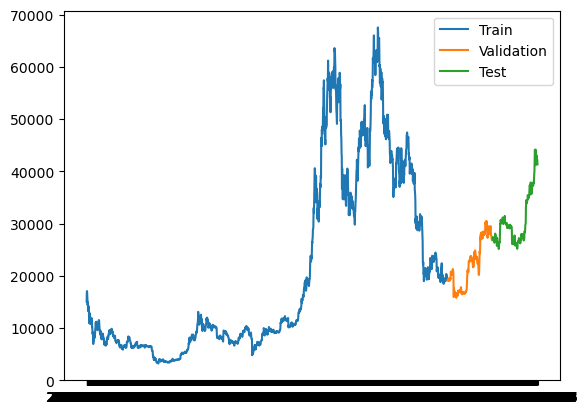

In [166]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [172]:
X_train.shape

(1740, 3, 1)

In [174]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(64),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(16, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.001),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
55/55 [==============================] - 3s 11ms/step - loss: 719692224.0000 - mean_absolute_error: 20439.6855 - val_loss: 509596256.0000 - val_mean_absolute_error: 22114.9219
Epoch 2/100
55/55 [==============================] - 0s 4ms/step - loss: 719551744.0000 - mean_absolute_error: 20436.2676 - val_loss: 509344320.0000 - val_mean_absolute_error: 22109.2227
Epoch 3/100
55/55 [==============================] - 0s 4ms/step - loss: 719145664.0000 - mean_absolute_error: 20426.2871 - val_loss: 508649248.0000 - val_mean_absolute_error: 22093.4980
Epoch 4/100
55/55 [==============================] - 0s 4ms/step - loss: 718170176.0000 - mean_absolute_error: 20402.6055 - val_loss: 507162784.0000 - val_mean_absolute_error: 22059.8340
Epoch 5/100
55/55 [==============================] - 0s 4ms/step - loss: 716328384.0000 - mean_absolute_error: 20357.8105 - val_loss: 504610624.0000 - val_mean_absolute_error: 22001.9121
Epoch 6/100
55/55 [==============================] - 0s 4ms/step

55/55 [==============================] - 0s 2ms/step


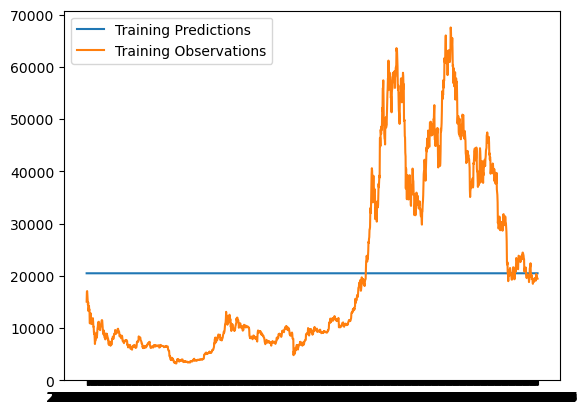

In [175]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

7/7 [==============================] - 0s 2ms/step


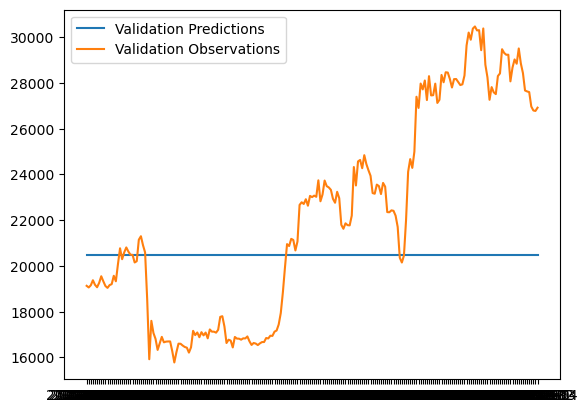

In [176]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])